In [23]:
import pandas as pd
import numpy as np

In [ ]:
import sys
sys.path.append('../lending_club')
import config
from data_prep import get_lending_club_data, refine_features

### Preproc for RF

In [24]:
df = pd.read_parquet('approved.parquet')

### Drop features we dont want

In [26]:
#drop features we dont want to use

df = df.drop(['fico_range_low','fico_range_high','application_type',
              'grade','earliest_cr_line','inq_last_6mths',
              'last_pymnt_d','total_pymnt','emp_title','disbursement_method',
              'application_type'], axis=1)

#drop missing in zip_code
df=df.loc[df.zip_code.notnull()]

In [27]:
#check missingness
df.isna().sum()

addr_state                 0
annual_inc                 0
dti                        0
emp_length                 0
home_ownership             0
initial_list_status        0
installment                0
int_rate                   0
issue_d                    0
loan_amnt                  0
loan_status                0
open_acc                   0
pub_rec                    0
pub_rec_bankruptcies       0
purpose                    0
sub_grade                  0
term                       0
verification_status        0
zip_code                   0
days_since_first_credit    0
fico_score_average         0
PnL                        0
dtype: int64

### Label encode rest of columns

In [28]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['initial_list_status'] = le.fit_transform(df['initial_list_status'])
df['sub_grade'] = le.fit_transform(df['sub_grade'])
df['addr_state'] = le.fit_transform(df['addr_state'])
df['home_ownership'] = le.fit_transform(df['home_ownership'])
df['purpose'] = le.fit_transform(df['purpose'])
df['verification_status'] = le.fit_transform(df['verification_status'])
df['zip_code'] = le.fit_transform(df['zip_code'])

### Separate into diff dataframes

In [30]:
from model_prep import divide_by_term

df_60= divide_by_term(df, 60)
df_36= divide_by_term(df, 36)
combined = pd.concat([df_60,df_36],axis=0)

In [33]:
#drop issue date, term, PnL
combined = combined.drop(['issue_d','PnL'], axis=1)
df_36 = df_36.drop(['issue_d','term','PnL'], axis=1)
df_60 = df_60.drop(['issue_d','term','PnL'], axis=1)


In [284]:
df_60['loan_status'].value_counts()

1    36525
0    11258
Name: loan_status, dtype: int64

### Final check of data types

In [34]:
combined.dtypes

addr_state                   int64
annual_inc                 float64
dti                        float64
emp_length                   int64
home_ownership               int64
initial_list_status          int64
installment                float64
int_rate                   float64
loan_amnt                  float64
loan_status                  int64
open_acc                   float64
pub_rec                    float64
pub_rec_bankruptcies       float64
purpose                      int64
sub_grade                    int64
term                         int64
verification_status          int64
zip_code                     int64
days_since_first_credit      int64
fico_score_average         float64
dtype: object

In [35]:
# take a random sample 
sample= combined.sample(n=10000)

# Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold

## 60 month

In [349]:
loan_targ = pd.Series(df_60.loan_status, name='target')
loan_feature = df_60.drop('loan_status',axis=1)

skf = StratifiedKFold(n_splits=5, shuffle=True)
rfc= RandomForestClassifier(class_weight='balanced')

In [151]:
#first test some parameters from random grid search
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = np.linspace(5, 50, 10)
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [302]:
rf_random = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = skf, 
                               verbose=2, random_state=42, n_jobs = -1)

In [350]:
#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(loan_feature, 
                                                loan_targ, stratify= loan_targ)

In [154]:
rf_random.fit(Xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [500, 611, 722, 833,
                                                         944, 1055, 1166, 1277,
                                                         1388, 1500]},
                   random_state=42, verbose=2)

In [155]:
rf_random.best_params_

{'n_estimators': 1166,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40.0,
 'bootstrap': True}

In [156]:
rf_random.score(Xtrain,ytrain)

1.0

In [157]:
rf_random.score(Xtest,ytest)

0.7637702996819019

In [351]:
#use random grid search param results - tuned
grid_para_forest = {'n_estimators': [1500],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'max_features': ['auto'],
 'max_depth': [12],
 'bootstrap': [True]}

In [352]:
grid_search_forest = GridSearchCV(estimator=rfc, 
                                     param_grid=grid_para_forest, 
                                     cv=skf, verbose=2)

%time grid_search_forest.fit(Xtrain, ytrain)  

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  51.1s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  50.9s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  51.3s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  51.6s
[CV] END bootstrap=True, max_depth=12, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  51.5s
CPU times: user 5min 14s, sys: 3.13 s, total: 5min 17s
Wall time: 5min 20s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'bootstrap': [True], 'max_depth': [12],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [1500]},
             verbose=2)

In [353]:
grid_search_forest.best_params_

{'bootstrap': True,
 'max_depth': 12,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1500}

In [354]:
best_rf_60 = grid_search_forest.best_estimator_

In [355]:
best_rf_60.score(Xtrain, ytrain)

0.8179256076122443

In [356]:
best_rf_60.score(Xtest, ytest)

0.6604721245605224

In [357]:
y_pred = best_rf_60.predict(Xtest)

### Confusion Matrix & PnL Analysis

In [358]:
from model_analysis import output_confusion_matrix

output_confusion_matrix(best_rf_60, Xtest, ytest)

,Pred: Charged Off,Pred: Fully Paid
True: Charged Off,1101,1714
True: Fully Paid,2342,6789


In [359]:
PnL = df.PnL

In [360]:
from model_analysis import calculate_PnL_return

calculate_PnL_return(best_rf_60, Xtest, ytest, PnL)

0.1770435078178414

## 36 Month

In [90]:
loan_targ = pd.Series(df_36.loan_status, name='target')
loan_feature = df_36.drop('loan_status',axis=1)

skf = StratifiedKFold(n_splits=5, shuffle=True)
rfc= RandomForestClassifier(class_weight='balanced')

In [91]:
#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(loan_feature, 
                                                loan_targ, stratify= loan_targ)

In [92]:
grid_search_forest = GridSearchCV(estimator=rfc, 
                                     param_grid=grid_para_forest, 
                                     cv=skf, verbose=2)

%time grid_search_forest.fit(Xtrain, ytrain)  

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 6.8min
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 6.3min
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 6.3min
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 6.3min
[CV] END .max_depth=10, max_features=sqrt, n_estimators=1000; total time= 6.8min
CPU times: user 40min 22s, sys: 12.6 s, total: 40min 34s
Wall time: 40min 39s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [10], 'max_features': ['sqrt'],
                         'n_estimators': [1000]},
             verbose=2)

In [93]:
grid_search_forest.best_params_

{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}

In [94]:
best_rf_36 = grid_search_forest.best_estimator_

In [95]:
best_rf_36.score(Xtrain, ytrain)

0.6263395963813501

In [96]:
best_rf_36.score(Xtest, ytest)

0.6152596555323591

### Confusion Matrix & PnL Analysis

In [97]:
from model_analysis import output_confusion_matrix

output_confusion_matrix(best_rf_36, Xtest, ytest)

,Pred: Charged Off,Pred: Fully Paid
True: Charged Off,13716,7343
True: Fully Paid,51630,80591


In [98]:
from model_analysis import calculate_PnL_return

calculate_PnL_return(best_rf_36, Xtest, ytest, PnL)

0.08414842994332775

## Combined

In [99]:
loan_targ = pd.Series(combined.loan_status, name='target')
loan_feature = combined.drop('loan_status',axis=1)

skf = StratifiedKFold(n_splits=5, shuffle=True)
rfc= RandomForestClassifier(class_weight='balanced')

In [100]:
#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(loan_feature, 
                                                loan_targ, stratify= loan_targ)

In [104]:
#use random grid search param results - tuned
grid_para_forest = {'n_estimators': [1000],
 'max_features': ['auto'],
 'max_depth': [10]}

In [105]:
grid_search_forest = GridSearchCV(estimator=rfc, 
                                     param_grid=grid_para_forest, 
                                     cv=skf, verbose=2)

%time grid_search_forest.fit(Xtrain, ytrain)  

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .max_depth=10, max_features=auto, n_estimators=1000; total time= 6.8min
[CV] END .max_depth=10, max_features=auto, n_estimators=1000; total time= 7.0min
[CV] END .max_depth=10, max_features=auto, n_estimators=1000; total time= 7.2min
[CV] END .max_depth=10, max_features=auto, n_estimators=1000; total time= 6.6min
[CV] END .max_depth=10, max_features=auto, n_estimators=1000; total time= 6.6min
CPU times: user 42min 1s, sys: 14.1 s, total: 42min 15s
Wall time: 42min 19s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [10], 'max_features': ['auto'],
                         'n_estimators': [1000]},
             verbose=2)

In [106]:
grid_search_forest.best_params_

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1000}

In [107]:
best_rf_total = grid_search_forest.best_estimator_

In [108]:
best_rf_total.score(Xtrain, ytrain)

0.624537753416035

In [109]:
best_rf_total.score(Xtest, ytest)

0.6157747569995037

In [116]:
y_pred = best_rf_total.predict(Xtest)

### Confusion Matrix & PnL Analysis

In [112]:
from model_analysis import output_confusion_matrix, calculate_PnL_return

output_confusion_matrix(best_rf_total, Xtest, ytest)

,Pred: Charged Off,Pred: Fully Paid
True: Charged Off,15570,8304
True: Fully Paid,55180,86172


In [113]:
calculate_PnL_return(best_rf_total, Xtest, ytest, PnL)

0.08733575677541719

### Investigate

In [118]:
Xtest1= Xtest.copy()
Xtest1['y_pred']=y_pred
Xtest1['ytrue']=ytest

In [123]:
Xtest2 = Xtest1.loc[Xtest1['ytrue']==0]
Xtest3= Xtest2.loc[Xtest2['y_pred']==1]
Xtest3['y_pred'].value_counts()

1    8304
Name: y_pred, dtype: int64

In [124]:
import seaborn as sns

#### Compare Distributions of false predictions to df

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

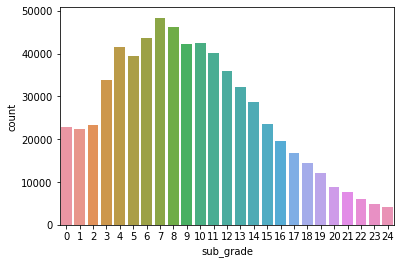

In [128]:
sns.countplot(x= combined['sub_grade'])

<AxesSubplot:xlabel='sub_grade', ylabel='count'>

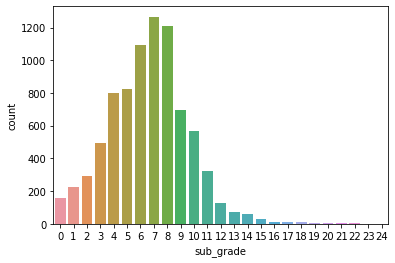

In [129]:
sns.countplot(x= Xtest3['sub_grade'])

<AxesSubplot:xlabel='term', ylabel='count'>

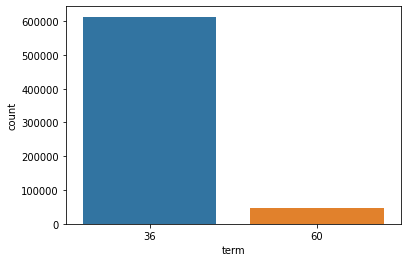

In [131]:
sns.countplot(x=combined['term'])

<AxesSubplot:xlabel='term', ylabel='count'>

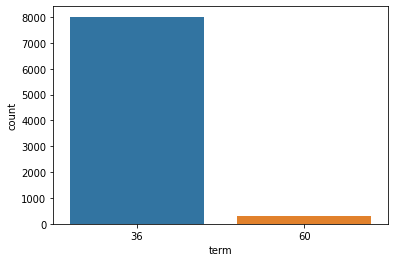

In [132]:
sns.countplot(x= Xtest3['term'])

<AxesSubplot:xlabel='addr_state', ylabel='count'>

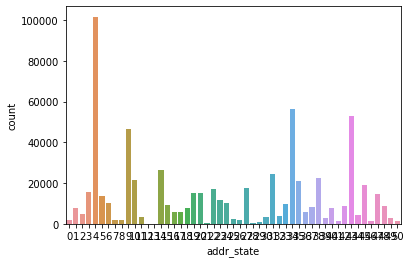

In [133]:
sns.countplot(x= combined['addr_state'])

<AxesSubplot:xlabel='addr_state', ylabel='count'>

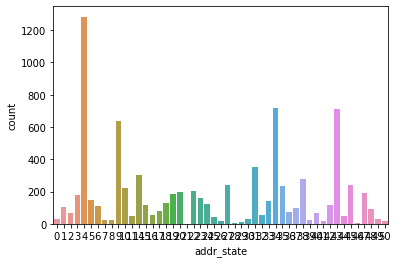

In [134]:
sns.countplot(x= Xtest3['addr_state'])

<AxesSubplot:xlabel='purpose', ylabel='count'>

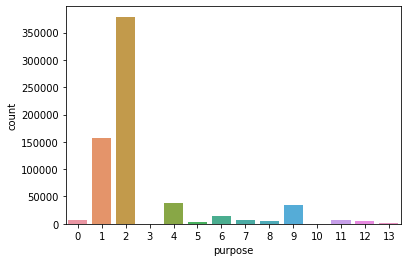

In [135]:
sns.countplot(x= combined['purpose'])

<AxesSubplot:xlabel='purpose', ylabel='count'>

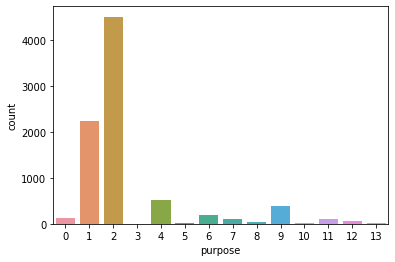

In [136]:
sns.countplot(x= Xtest3['purpose'])

### Feature importance

In [137]:
from model_analysis import get_feature_importance, graph_importance

In [139]:
get_feature_importance(best_rf_total, Xtrain)

sub_grade                  0.320277
int_rate                   0.249650
fico_score_average         0.077832
dti                        0.060521
annual_inc                 0.059680
installment                0.030042
days_since_first_credit    0.027434
loan_amnt                  0.023257
term                       0.022224
home_ownership             0.021772
zip_code                   0.021740
emp_length                 0.019830
open_acc                   0.017241
verification_status        0.014474
addr_state                 0.013351
purpose                    0.011211
pub_rec                    0.004252
pub_rec_bankruptcies       0.002886
initial_list_status        0.002328
dtype: float64